In [1]:
%matplotlib inline

In [2]:
import warnings
warnings.filterwarnings("ignore")

from dataclasses import dataclass
from datetime import datetime
import math
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import operator
import pandas as pd
import seaborn as sns

mpl.rcParams['figure.figsize'] = [8, 5]
sns.set_style('whitegrid', {'axes.labelcolor': '0 ', "text.color": '0', 'xtick.color': '0', 'ytick.color': '0', 'font.sans-serif': ['DejaVu Sans', 'Liberation Sans', 'Bitstream Vera Sans', 'sans-serif'],})
sns.set_context('notebook', font_scale=1)

## NPHET IEMAG 2021 October/November Model Scenario Projections vs Reported Data (*WORK IN PROGRESS*)

This notebook compares the NPHET IEMAG October/November 2021 model scenario projections with reported data. 

* October projections: The projections are estimated reproductions of the age-cohorted SEIR model Conservative/Pessimistic scenarios from Figure 2 and Figure 3 in the [2021-10-18 NPHET letter to the Minister for Health](https://assets.gov.ie/202162/b27ff483-3b4b-4970-ac55-ed551bbf9186.pdf). This letter states: 
  * "*The spread of infection within the population is limited by this age structure, and as such this model tends to generate lower estimates of infection than the homogeneous model. At this point in the pandemic **we have reason to believe that the estimates from the age-cohorted model are more accurate**.*"
  * "*It is informative, rather than recalibrating and re-running these models, to see how they have performed since **they were originally calibrated and run in August 2021**.*"
  
The October letter also contains "*low child transmission*" alternative projections for both the Conservative and Pessimistic scenarios. For now, these are excluded, as the main Conservative/Pessimistic projections correspond more closely to the August projections being compared. The latter were also covered in a number of media articles, for example:
* [2021-08-31: Nphet letter to Donnelly warns of 3,000 Covid cases per day in September](https://www.irishtimes.com/news/health/nphet-letter-to-donnelly-warns-of-3-000-covid-cases-per-day-in-september-1.4661421)
  * "*Modelling given to the Government suggests 2,500-3,000 cases per day next month, even in optimistic scenarios, and peaks of between 500-700 in hospital and 80-130 needing intensive care.*"
* [2021-09-01: 1,789 new cases of Covid-19 as NPHET warns peak ahead](https://www.rte.ie/news/coronavirus/2021/0901/1244069-covid-nphet/)
  * "*The figures come as the Government has been told by the National Public Health Emergency Team that Ireland could see a peak of 2,500-3,000 Covid-19 cases a day by mid September, in an optimistic scenario.*"

In [3]:
@dataclass
class ScenarioCurve:
    name: str
    fit_dates: pd.DatetimeIndex
    fit_cases: np.array
        
@dataclass(frozen=True)
class Scenario:
    name: str
    cases: np.array
    mean_cases: int
    hospital_cases: np.array
    hospital_cases_upper: np.array
    hospital_cases_lower: np.array
    mean_hospital_cases: int
    icu_cases: np.array
    icu_cases_upper: np.array
    icu_cases_lower: np.array
    mean_icu_cases: int
    #mean_deaths: int
    dates: pd.DatetimeIndex
    color: int

### Scenario data 2021-08-11 to 2022-01-31, based on the figures from the NPHET letters mentioned above

In [4]:
oct_scenario_dates = pd.date_range('2021-08-26', '2021-12-27')
nov_scenario_dates = pd.date_range('2021-11-10', '2022-01-31')

def daily_fit(fit_dates, fit_cases, fit_deg=3):
    fit_dates = [datetime.strptime(x, '%Y%m%d') for x in fit_dates]
    days = [((x - fit_dates[0]).days) for x in fit_dates]
    pf = np.poly1d(np.polyfit(days, fit_cases, deg=fit_deg))
    daily_cases = pf(range(0, days[-1] + 1))
    return daily_cases, int(daily_cases.sum())

scenarios = {}
for name, fit_deg, fit_cases_dates, fit_cases, fit_hosp_dates, fit_hosp, fit_hosp_lower, fit_hosp_upper, fit_icu_dates, fit_icu, fit_icu_lower, fit_icu_upper, color, scenario_dates in     [
        ('Nov-rfitz77',
         3,
         # TODO: cases require estimates, excluded for now
         ['20210826', '20210830', '20210906', '20210909', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025', '20211227'], 
         [1950, 2200, 2490, 2505, 2510, 2505, 2490, 2400, 2120, 2090, 1950, 1000],
         ['20211110', '20211115', '20211122', '20220101', '20220114', '20220131'], 
         [      570,        730,        800,        500,        300,       250],
         None,
         None,
         ['20211110', '20211127', '20220107', '20220117', '20220131'], 
         [      100,        140,        100,        70,          55],
         None,
         None,
         8,
         nov_scenario_dates
        ),
        ('Nov-Optimistic',
         4,
         # TODO: cases require estimates, excluded for now
         ['20210826', '20210830', '20210906', '20210909', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025', '20211227'], 
         [1950, 2200, 2490, 2505, 2510, 2505, 2490, 2400, 2120, 2090, 1950, 1000],
         ['20211110', '20211115', '20211129', '20211208', '20211220', '20220101', '20220114', '20220131'], 
         [       570,        730,      1000,       1200,       1000,        750,        500,        250],
         [       560,        690,       910,       1050,        920,        740,        490,        250],
         [       580,        800,      1125,       1250,       1125,        800,        500,        250],
         ['20211110', '20211122', '20211206', '20211216', '20211225', '20220107', '20220117', '20220131'], 
         [      100,        150,        200,        220,        200,        150,        100,         55],
         [       80,        115,        150,        157,        150,        120,         67,         40],
         [      120,        190,        260,        280,        255,        180,        130,         65],
         0,
         nov_scenario_dates
        ),
        ('Nov-Pessimistic',
         4,
         # TODO: cases require estimates, excluded for now
         ['20210826', '20210830', '20210906', '20210909', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025', '20211227'], 
         [1950, 2200, 2490, 2505, 2510, 2505, 2490, 2400, 2120, 2090, 1950, 1000],
         ['20211110', '20211115', '20211122', '20211129', '20211206', '20211218', '20211228', '20220106', '20220117', '20220131'], 
         [       625,        730,      1000,       1500,       1750,       2250,       2000,       1500,       1000,        500],
         [       600,        720,       960,       1450,       1625,       2100,       1750,       1420,        950,        490],
         [       660,        770,      1040,       1670,       2000,       2550,       2175,       1625,       1050,        510],
         ['20211110', '20211122', '20211129', '20211208', '20211214', '20211219', '20211224', '20211231', '20220108', '20220110', '20220124', '20220131'], 
         [      100,        150,        200,        300,        350,        400,        430,        400,        350,        300,        200,        140],
         [       80,        130,        160,        230,        280,        300,        340,        305,        250,        200,        140,        110],
         [      125,        210,        280,        420,        460,        530,        550,        520,        450,        375,        230,        175],
         6,
         nov_scenario_dates
        ),
        ('Oct-Conservative - low child transmission',
         4,
         # TODO: cases require estimates, excluded for now
         ['20210826', '20210830', '20210906', '20210909', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025', '20211227'], 
         [1950, 2200, 2490, 2505, 2510, 2505, 2490, 2400, 2120, 2090, 1950, 1000],
         ['20210826', '20210906', '20210920', '20211004', '20211018', '20211101', '20211115', '20211129', '20211213', '20211227'], 
         [280, 270, 260, 260, 265, 250, 240, 210, 170, 130],
         None,
         None,
         ['20210826', '20210906', '20210920', '20211004', '20211018', '20211023', '20211101', '20211115', '20211129', '20211213', '20211227'], 
         [68, 67, 68, 71, 73, 75, 70, 65, 57, 47, 40],
         None,
         None,
         8,
         oct_scenario_dates
        ),
        ('Oct-Pessimistic - low child transmission',
         4,
         # TODO: cases require estimates, excluded for now
         ['20210826', '20210830', '20210906', '20210909', '20210913', '20210920', '20210927', '20211004', '20211011', '20211018', '20211025', '20211227'], 
         [1950, 2200, 2490, 2505, 2510, 2505, 2490, 2400, 2120, 2090, 1950, 1000],
         ['20210826', '20210906', '20210920', '20210925', '20211004', '20211018', '20211101', '20211112', '20211115', '20211129', '20211213', '20211227'], 
         [280, 270, 260, 255, 350, 500, 690, 750, 730, 630, 490, 310],
         None,
         None,
         ['20210826', '20210906', '20210920', '20210930', '20211004', '20211018', '20211101', '20211115', '20211129', '20211213', '20211227'], 
         [68, 67, 68, 71, 77, 116, 160, 195, 162, 130, 90],
         None,
         None,
         2,
         oct_scenario_dates
        ),
        ]:

    
    daily_cases, mean_cases = daily_fit(fit_cases_dates, fit_cases, fit_deg)
    daily_hospital_cases, mean_hospital_cases = daily_fit(fit_hosp_dates, fit_hosp, fit_deg)
    if fit_hosp_lower and fit_hosp_upper:
        daily_hospital_cases_upper = daily_hospital_cases + 20
        daily_hospital_cases_lower = daily_hospital_cases - 20
        daily_hospital_cases_upper, _ = daily_fit(fit_hosp_dates, fit_hosp_lower, fit_deg)
        daily_hospital_cases_lower, _ = daily_fit(fit_hosp_dates, fit_hosp_upper, fit_deg)
    else:
        daily_hospital_cases_upper = daily_hospital_cases
        daily_hospital_cases_lower = daily_hospital_cases
    daily_icu_cases, mean_icu_cases = daily_fit(fit_icu_dates, fit_icu, fit_deg)
    if fit_icu_lower and fit_icu_upper:
        daily_icu_cases_upper = daily_icu_cases + 20
        daily_icu_cases_lower = daily_icu_cases - 20
        daily_icu_cases_upper, _ = daily_fit(fit_icu_dates, fit_icu_lower, fit_deg)
        daily_icu_cases_lower, _ = daily_fit(fit_icu_dates, fit_icu_upper, fit_deg)
    else:
        daily_icu_cases_upper = daily_icu_cases
        daily_icu_cases_lower = daily_icu_cases
    
    # Oct age-cohort model excludes ICU cases from hospital cases
    # They were included in the Nov homogeneous model projections, 
    # so include them in the Oct projections now
    if name.startswith('Oct'):
        daily_hospital_cases += daily_icu_cases
        mean_hospital_cases += mean_icu_cases
        
    scenarios[name] = Scenario(name=name, 
                               cases=daily_cases,
                               mean_cases=mean_cases,
                               hospital_cases=daily_hospital_cases,
                               hospital_cases_upper=daily_hospital_cases_upper,
                               hospital_cases_lower=daily_hospital_cases_lower,
                               mean_hospital_cases=mean_hospital_cases,
                               icu_cases=daily_icu_cases,
                               icu_cases_upper=daily_icu_cases_upper,
                               icu_cases_lower=daily_icu_cases_lower,
                               mean_icu_cases=mean_icu_cases,
                               dates=scenario_dates, 
                               color=color)

scenariodf = pd.DataFrame({'Date': np.concatenate([x.dates for x in scenarios.values()]), 
                           'Scenario': np.concatenate([[x] * len(y.dates) for x, y in scenarios.items()]), 
#                           'DailyCases': np.concatenate([x.cases for x in scenarios.values()]),
#                           'Cases': np.concatenate([[x.mean_cases] * len(x.dates) for x in scenarios.values()]),
                           'InHospital': np.concatenate([x.hospital_cases for x in scenarios.values()]),
                           'InHospitalUpper': np.concatenate([x.hospital_cases_upper for x in scenarios.values()]),
                           'InHospitalLower': np.concatenate([x.hospital_cases_lower for x in scenarios.values()]),
                           'HospitalCases': np.concatenate([[x.mean_hospital_cases] * len(x.dates) for x in scenarios.values()]),
                           'InIcu': np.concatenate([x.icu_cases for x in scenarios.values()]),
                           'InIcuUpper': np.concatenate([x.icu_cases_upper for x in scenarios.values()]),
                           'InIcuLower': np.concatenate([x.icu_cases_lower for x in scenarios.values()]),
                           'IcuCases': np.concatenate([[x.mean_icu_cases] * len(x.dates) for x in scenarios.values()]),
                          })

In [5]:
reporteddf = pd.read_csv('./data/reportedcases.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y-%m-%d"))
reporteddf = reporteddf[reporteddf.Date>='2021-08-11']#11-01']

#reporteddf['DailyCases'] = reporteddf.Cases
#reporteddf.Cases = reporteddf.Cases.cumsum()

# Oct hospital projections exclude ICU, Nov projections appear to have used InHospital = Hospital + ICU
#reporteddf.InHospital = reporteddf.InHospital - reporteddf.InIcu

reporteddf.HospitalCases = reporteddf.HospitalCases.cumsum()
reporteddf.IcuCases = reporteddf.IcuCases.cumsum()
reporteddf.Deaths = reporteddf.Deaths.cumsum()
reporteddf['Scenario'] = 'Reported'

In [6]:
meanreporteddf = reporteddf.copy(deep=True)
meanreporteddf['InHospital'] = reporteddf.InHospital.rolling(7).mean().dropna()
meanreporteddf['InIcu'] = reporteddf.InIcu.rolling(7).mean().dropna()
meanreporteddf['Scenario'] = 'Reported (7-day average)'

In [7]:
#hospdf = pd.read_csv('data/Covid19AcuteHospitalHistoricSummaryOpenData.csv', parse_dates=["Date"], date_parser=lambda x: datetime.strptime(x, "%Y/%m/%d %H:00:00+00"))
#hospdf = hospdf[hospdf.Date>='2021-08-11']
#hospadmissionsdf = reporteddf[['Date']].copy(deep=True)
#hospadmissionsdf['InHospital'] = (hospdf.SUM_number_of_confirmed_covid_1 * (hospdf.SUM_no_new_admissions_covid19_p/hospdf.SUM_number_of_new_covid_19_cases_co)).values
#hospadmissionsdf.InHospital = hospadmissionsdf.InHospital.astype(int)
#hospadmissionsdf['Scenario'] = 'Reported (Admissions)'
#hospnonadmissionsdf = reporteddf[['Date']].copy(deep=True)
#hospnonadmissionsdf['InHospital'] = hospdf.SUM_number_of_confirmed_covid_1.values - hospadmissionsdf.InHospital.values
#hospnonadmissionsdf['Scenario'] = 'Reported (Non-Admissions)'
#hospdf = pd.concat((hospadmissionsdf, hospnonadmissionsdf), ignore_index=True)

### NPHET scenarios vs reported cases

In [8]:
default_palette = sns.color_palette()
num_month_scenarios = lambda plot_scenarios, month: len([x for x in plot_scenarios if x.startswith(month)])

def generate_dashes(plot_scenarios):
    return [(4,2)] * num_month_scenarios(plot_scenarios, 'Nov') + [(2,1)] * num_month_scenarios(plot_scenarios, 'Oct') + ['']

def generate_palette(plot_scenarios):
    return [default_palette[scenarios[x].color] for x in plot_scenarios] + default_palette[5:6]

def plot_cases(plot_scenarios, model_title, case_type='Cases', y='Cases', ylabel='Cases', legend_loc='upper left', plot_scenario='all', plot_type='cases', value_type='(Cumulative)'):
    # Enable Oct-only, Nov-only, Oct vs Nov plots
    dashes=generate_dashes(plot_scenarios)
    palette=generate_palette(plot_scenarios)
    hue_order = plot_scenarios + ['Reported']
    plot_scenariodf = scenariodf[scenariodf.Scenario.isin(plot_scenarios)].copy(deep=True)
    months = set([x.split('-')[0] for x in plot_scenarios])
    
    datadf = reporteddf.copy(deep=True)
    
    if len(months) == 1:      
        # Remove month prefix
        remove_prefix = lambda x: ' '.join(x.split('-')[1:])
        plot_scenarios = [remove_prefix(x) for x in plot_scenarios]
        plot_scenariodf.Scenario = plot_scenariodf.Scenario.apply(remove_prefix)
        datadf = datadf[datadf.Date>='2021-11-01']
        
    # TBC
#    if case_type == 'Cases In Hospital':    
#        datadf.Scenario = 'Reported (All)'
#        datadf = pd.concat((datadf, hospdf[hospdf.Date>=datadf.Date.values[0]]))
#        dashes += [(2,1), (1,2)]
#        palette += [default_palette[5]] * 2
#        hue_order = plot_scenarios + ['Reported (All)', 'Reported (Admissions)', 'Reported (Non-Admissions)']
#    else:
#        hue_order = plot_scenarios + ['Reported']

    datadf = pd.concat((datadf, meanreporteddf[meanreporteddf.Date>=datadf.Date.values[0]]))
        
    dashes = dashes[:-1] + [(4,2), '']
    palette += [default_palette[5]]
    hue_order = plot_scenarios + ['Reported (7-day average)', 'Reported']

    ax = sns.lineplot(data=pd.concat((plot_scenariodf, datadf), ignore_index=True), x='Date', y=y, hue='Scenario', hue_order=hue_order, style='Scenario', dashes=dashes, palette=palette)
    sns.despine(left=True, bottom=True)
    
    for i, scenario in enumerate([s for s in plot_scenarios if not s.startswith('Oct') and not s.startswith('Reported')]):
        currentdf = plot_scenariodf[plot_scenariodf.Scenario==scenario]
        scenario_values = currentdf[y]
        colorkey = scenario if scenario.startswith('Nov') else f'Nov-{scenario}'
        ax.fill_between(currentdf.Date, currentdf[f'{y}Lower'], currentdf[f'{y}Upper'], color=default_palette[scenarios[colorkey].color], alpha=0.2)
            
    ax.set_title(f'NPHET IEMAG {"/".join(sorted(months, reverse=True))} 2021 {model_title} Scenarios vs Reported {case_type} {value_type}\n@dgocallaghan')
    ax.set_ylabel(ylabel)
    plt.legend(loc=legend_loc)
    ax.set_ylim((-1*ax.get_ylim()[1]/50, ax.get_ylim()[1]))
    plt.xticks(rotation=30);
    if plot_scenario and plot_type:
        plt.savefig(f'./figures/nphet2021{"".join(sorted(months)).lower()}_{plot_scenario}_scenarios_vs_reported_{plot_type}.png', bbox_inches='tight')
              
def plot_hospital_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Hospital Cases', 
               y='HospitalCases', 
               ylabel='New Hospital Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='hospital_cases')
    
def plot_icu_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='ICU Cases', 
               y='IcuCases', 
               ylabel='New ICU Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='icu_cases')
    
def plot_deaths(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Deaths', 
               y='Deaths', 
               ylabel='Deaths',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario,
               plot_type='deaths')
    
def plot_daily_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Daily Cases', 
               y='DailyCases', 
               ylabel='New Daily Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='daily_cases',
               value_type='')
    
def plot_daily_hospital_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Cases In Hospital', 
               y='InHospital', 
               ylabel='Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='daily_hospital_cases',
               value_type='')
    
def plot_daily_icu_cases(plot_scenarios, model_title, legend_loc='upper left', plot_scenario='all'):
    plot_cases(plot_scenarios=plot_scenarios, 
               model_title=model_title, 
               case_type='Cases In ICU', 
               y='InIcu', 
               ylabel='Cases',
               legend_loc=legend_loc, 
               plot_scenario=plot_scenario, 
               plot_type='daily_icu_cases',
               value_type='')
    


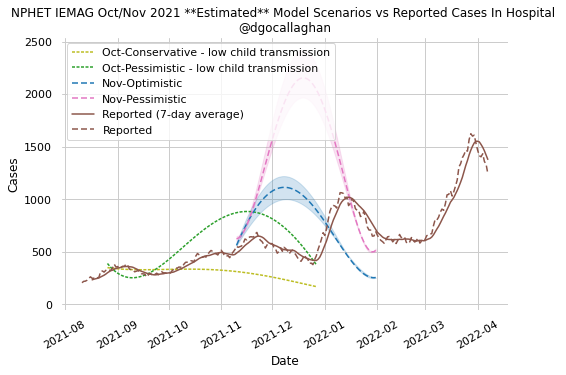

In [9]:
plot_daily_hospital_cases(plot_scenarios=['Oct-Conservative - low child transmission', 'Oct-Pessimistic - low child transmission', 'Nov-Optimistic', 'Nov-Pessimistic'],
           model_title='**Estimated** Model', 
           plot_scenario='all')

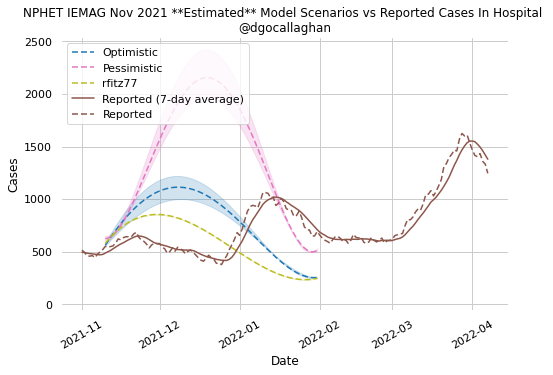

In [10]:
plot_daily_hospital_cases(plot_scenarios=['Nov-Optimistic', 'Nov-Pessimistic', 'Nov-rfitz77'],
           model_title='**Estimated** Model', 
           plot_scenario='all')

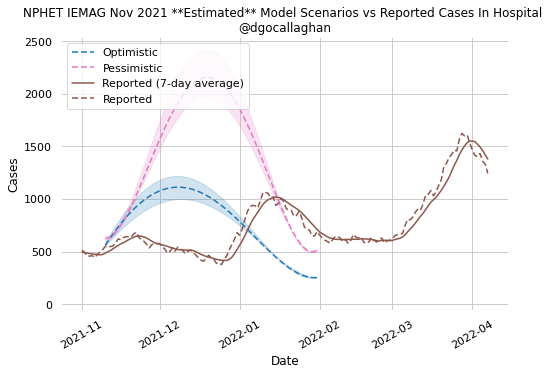

In [11]:
plot_daily_hospital_cases(plot_scenarios=['Nov-Optimistic', 'Nov-Pessimistic'],
           model_title='**Estimated** Model', 
           plot_scenario='all')

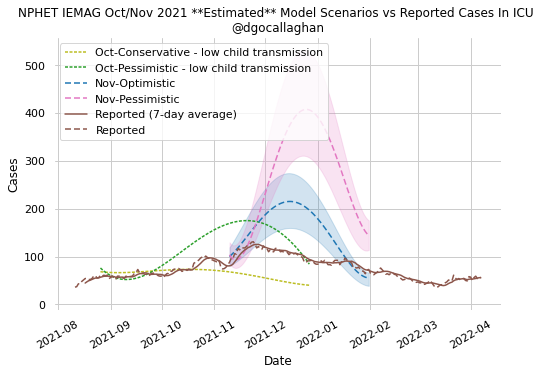

In [12]:
plot_daily_icu_cases(plot_scenarios=['Oct-Conservative - low child transmission', 'Oct-Pessimistic - low child transmission', 'Nov-Optimistic', 'Nov-Pessimistic'],
           model_title='**Estimated** Model', 
           plot_scenario='all')

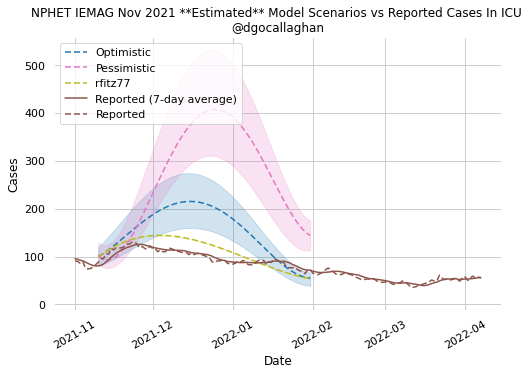

In [13]:
plot_daily_icu_cases(plot_scenarios=['Nov-Optimistic', 'Nov-Pessimistic', 'Nov-rfitz77'],
           model_title='**Estimated** Model', 
           plot_scenario='all')

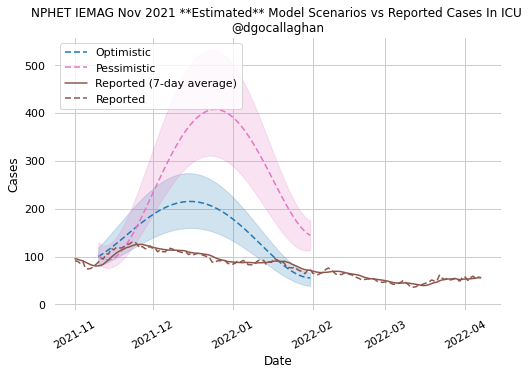

In [14]:
plot_daily_icu_cases(plot_scenarios=['Nov-Optimistic', 'Nov-Pessimistic'],
           model_title='**Estimated** Model', 
           plot_scenario='all')